In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from pima_api.data.preprocess import preprocess_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
[k for k in vars(XGBClassifier).keys() if not k.startswith("__")]

['_more_tags',
 'fit',
 'predict',
 'predict_proba',
 'classes_',
 'set_fit_request',
 'set_predict_request',
 'set_predict_proba_request',
 'set_score_request']

In [ ]:
df = preprocess_dataset("../pima_api/data/pima.csv")
columns = df.columns.tolist()
columns.remove("Outcome")
columns.insert(0, "Outcome")
df = df[columns]

train_set, test_set = train_test_split(
    df, train_size=700, random_state=42, stratify=df["Outcome"]
)

X_train, X_valid, y_train, y_valid = train_test_split(
    train_set.iloc[:, 1:],
    train_set["Outcome"],
    train_size=0.8,
    random_state=42,
    stratify=train_set["Outcome"],
)
X_test = test_set.iloc[:, 1:]
y_test = test_set["Outcome"]

In [4]:
std_scaler = StandardScaler()

X_train_sc = std_scaler.fit_transform(X_train)
X_valid_sc = std_scaler.transform(X_valid)
X_test_sc = std_scaler.transform(X_test)

In [5]:
param_distrib = {
    "max_depth": [3, 4, 5],
    "eta": [0.1, 0.01, 0.05],
    "n_estimators": [50, 100, 200],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb_clf = XGBClassifier(objective="binary:logistic", random_state=42)
random_search = RandomizedSearchCV(
    xgb_clf, param_distributions=param_distrib, cv=3, n_jobs=-1
)
random_search.fit(X_train_sc, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'eta': [0.1, 0.01, 0.05],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.8, 1.0]})

In [6]:
xgb_clf = random_search.best_estimator_
xgb_clf.fit(
    X_train_sc, y_train, eval_set=[(X_train_sc, y_train), (X_valid_sc, y_valid)]
)

train_loss = xgb_clf.evals_result()["validation_0"]["logloss"]
valid_loss = xgb_clf.evals_result()["validation_1"]["logloss"]
epochs = range(len(train_loss))

[0]	validation_0-logloss:0.64314	validation_1-logloss:0.64410
[1]	validation_0-logloss:0.64027	validation_1-logloss:0.64142
[2]	validation_0-logloss:0.63760	validation_1-logloss:0.63879
[3]	validation_0-logloss:0.63469	validation_1-logloss:0.63580
[4]	validation_0-logloss:0.63181	validation_1-logloss:0.63323
[5]	validation_0-logloss:0.62890	validation_1-logloss:0.62999
[6]	validation_0-logloss:0.62622	validation_1-logloss:0.62745
[7]	validation_0-logloss:0.62344	validation_1-logloss:0.62472
[8]	validation_0-logloss:0.62072	validation_1-logloss:0.62213
[9]	validation_0-logloss:0.61802	validation_1-logloss:0.61975
[10]	validation_0-logloss:0.61555	validation_1-logloss:0.61728
[11]	validation_0-logloss:0.61328	validation_1-logloss:0.61483
[12]	validation_0-logloss:0.61083	validation_1-logloss:0.61214
[13]	validation_0-logloss:0.60823	validation_1-logloss:0.60965
[14]	validation_0-logloss:0.60603	validation_1-logloss:0.60740
[15]	validation_0-logloss:0.60363	validation_1-logloss:0.60528
[1

In [7]:
best_params = random_search.best_params_
pd.DataFrame(best_params.values(), index=best_params.keys(), columns=[".best_params_"])

,.best_params_
subsample,0.80
n_estimators,200.00
max_depth,3.00
eta,0.01
colsample_bytree,1.00


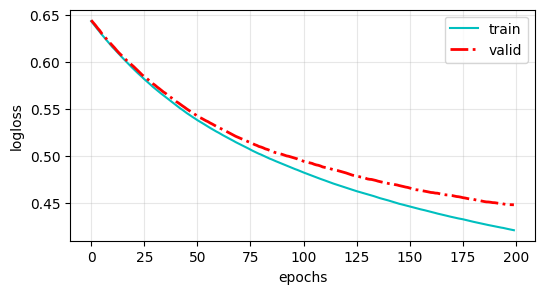

In [8]:
plt.figure(figsize=(6, 3))
plt.plot(epochs, train_loss, "c-", label="train")
plt.plot(epochs, valid_loss, "r-.", lw=2, label="valid")
plt.grid(alpha=0.3)
plt.gca().set_xlabel("epochs")
plt.gca().set_ylabel("logloss")
plt.legend()
plt.show()

['Outcome', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


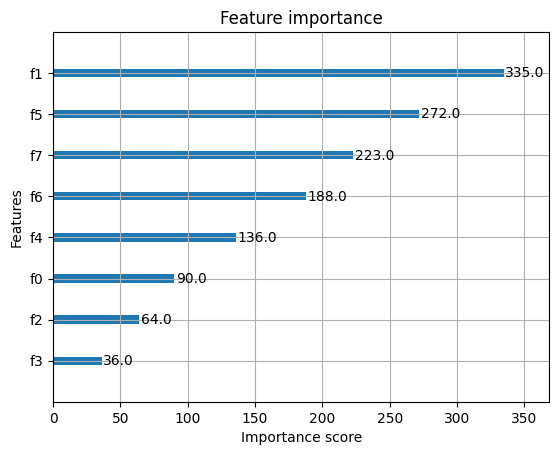

In [9]:
print(columns)
xgb.plot_importance(xgb_clf)
plt.show()

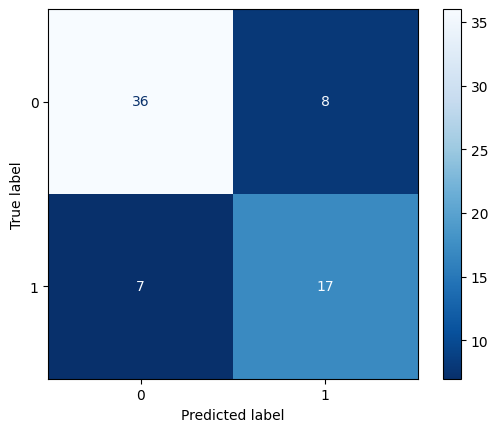

In [10]:
ConfusionMatrixDisplay.from_predictions(
    y_test, xgb_clf.predict(X_test_sc), cmap=plt.cm.Blues_r
)
plt.show()

In [14]:
print(f"Accuracy: {xgb_clf.score(X_test_sc, y_test):.3%}")

Accuracy: 77.941%
